In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

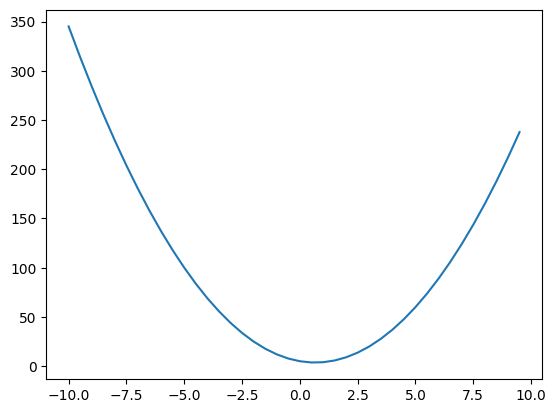

In [4]:
xs = np.arange(-10, 10, 0.5)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.0000000001
x = 2/3
(f(x + h) - f(x)) / h

0.0

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
d

4.0

In [7]:
h = 0.00001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
a += h
# b += h
# c += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 3.9999699999999994
slope -3.000000000064062


In [78]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward

        return out
    

    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e' #same as a.__add__(b)
d = e + c ; d.label = 'd'
# a.__mul__(b).__add__(c)
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [9]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [10]:
d._op

'+'

In [25]:
import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz-12.2.1-win64\bin"

from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label='{%s | data %.4f | grad %.4f}' % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)),str(id(n2)) + n2._op)
    return dot

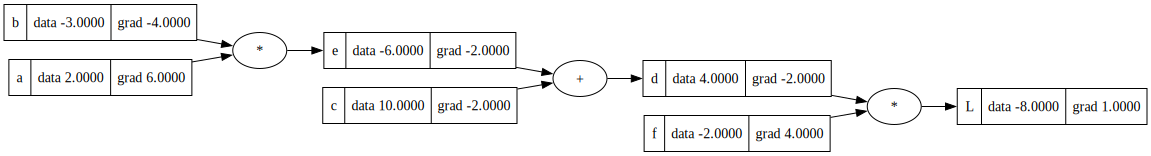

In [40]:
draw_dot(L)

In [ ]:
def lol():
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e' #same as a.__add__(b)
    d = e + c ; d.label = 'd'
    # a.__mul__(b).__add__(c)
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 , label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    c.data += h
    e = a * b; e.label = 'e' #same as a.__add__(b)
    d = e + c ; d.label = 'd'
    # a.__mul__(b).__add__(c)
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)
lol()

-1.9999999999988916


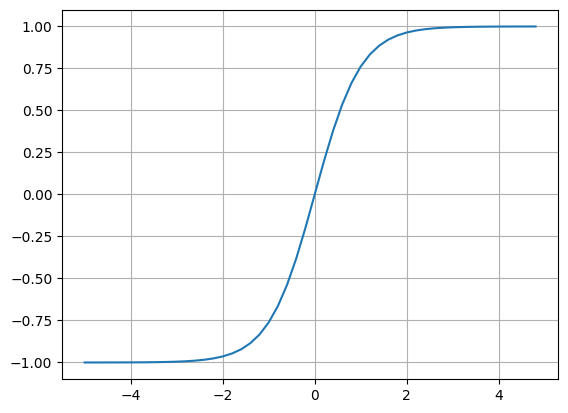

In [44]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

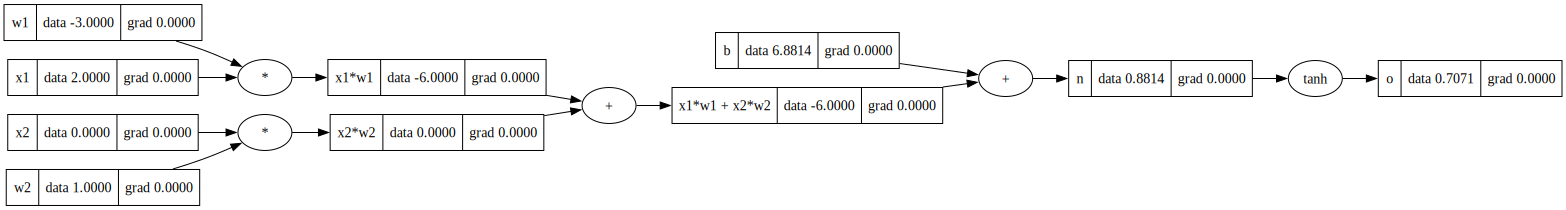

In [129]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad = other * self.data**(other - 1) * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x =  self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        
        topo = []
        visited = set()
        def topo_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topo_sort(child)
                topo.append(v)
            return topo
        topo_sort(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the nueron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

In [110]:
o.backward()

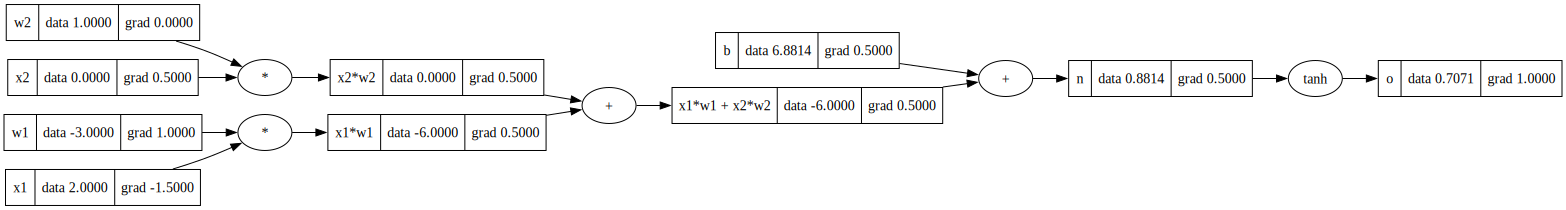

In [111]:
draw_dot(o)


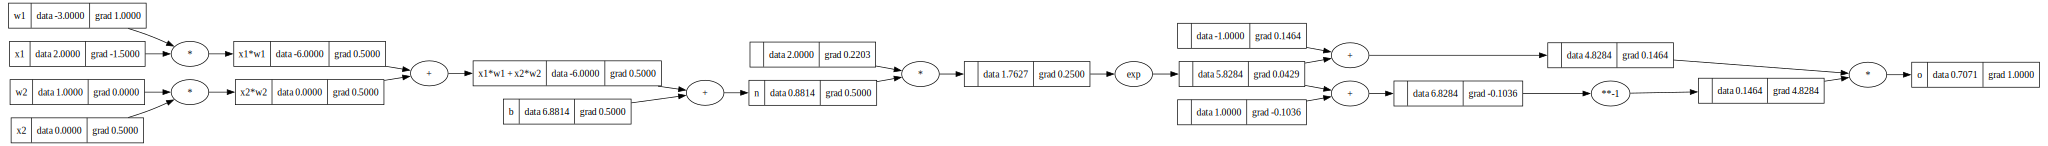

In [130]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the nueron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#-----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# o = n.tanh()
o.label = 'o'
o.backward()
draw_dot(o)

In [ ]:
# o = tanh(n)
# do /dn = 1 - o**2

    

Value(data=5.828427124746192)

In [131]:
import torch   

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [237]:
import random
class Neuron:
    def __init__(self, nin):
        # Initialize weights and bias as Value objects
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))  # Changed to Value object
    
    def __call__(self, x):
        # Perform weighted sum and add bias
        act = sum([wi * xi for wi, xi in zip(self.w, x)], self.b)
        out = act.tanh()  # Apply activation function
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs 
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
       

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer  in self.layers for p in layer.parameters()]
    
x = [Value(2.0), Value(3.0)]  # Inputs as Value objects
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
# n = Layer(2, 3)
n(x)


Value(data=0.19077434753622796)

In [253]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]




In [254]:
for k in range(500):
    ypred = [n(x) for x in xs]
    loss = sum([(b-a)**2 for a,b in zip(ys,ypred)], Value(0.0))
    
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)

0 0.001823199306908145
1 0.0018181392604133466
2 0.0018131052402296196
3 0.0018080970517494045
4 0.001803114502272198
5 0.001798157400981488
6 0.0017932255589219192
7 0.0017883187889769039
8 0.0017834369058464857
9 0.001778579726025527
10 0.0017737470677822
11 0.0017689387511368908
12 0.0017641545978411824
13 0.0017593944313573856
14 0.0017546580768381622
15 0.0017499453611065673
16 0.0017452561126362876
17 0.0017405901615322142
18 0.0017359473395112627
19 0.0017313274798834589
20 0.0017267304175332897
21 0.001722155988901326
22 0.0017176040319660788
23 0.001713074386226161
24 0.0017085668926826079
25 0.0017040813938215074
26 0.0016996177335968864
27 0.0016951757574137295
28 0.0016907553121113953
29 0.0016863562459470479
30 0.0016819784085795374
31 0.0016776216510533183
32 0.0016732858257827107
33 0.0016689707865363116
34 0.0016646763884216181
35 0.0016604024878698609
36 0.0016561489426211071
37 0.0016519156117094673
38 0.0016477023554485452
39 0.0016435090354170996
40 0.00163933551444

In [255]:
ypred

[Value(data=0.9888718141852721),
 Value(data=-0.9888900987903692),
 Value(data=-0.9841402676927546),
 Value(data=0.9847274703412069)]